In [157]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import requests
import tensorflow as tf 
import time
from sklearn.preprocessing import MinMaxScaler, normalize

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense

In [163]:
coin = 'BTC'
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym='+coin+'&tsym=USD&limit=2000')
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')
data.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-07-20,7333.93,7676.55,7279.34,7477.10,80874.93,6.030344e+08
2018-07-21,7405.40,7453.07,7220.37,7333.93,40295.77,2.974404e+08
2018-07-22,7398.64,7569.28,7345.25,7405.40,47479.76,3.555653e+08
2018-07-23,7718.00,7798.59,7376.66,7398.64,96722.04,7.455333e+08
2018-07-24,8136.08,8136.08,7692.16,7718.00,57760.53,4.577789e+08


In [164]:
# plt.figure(figsize = (18,9))
# plt.plot(range(data.shape[0]),(data['low']+data['high'])/2.0)
# plt.xticks(range(0,data.shape[0],500),df['time'].loc[::500],rotation=45)
# plt.xlabel('Date',fontsize=18)
# plt.ylabel('Mid Price',fontsize=18)
# plt.show()
data.to_csv('./data.csv', index_label=False, header=None, columns=['open', 'high', 'low', 'volumefrom', 'volumeto', 'close'])
data['time'] = data.index
cols = data.columns
cols = list(cols)
cols = cols[-1:] + cols[:-1]
data = data[cols]
data.head()

,time,close,high,low,open,volumefrom,volumeto
time,,,,,,,
2013-01-31,2013-01-31,20.41,21.43,19.51,19.70,99226.70,2042238.64
2013-02-01,2013-02-01,20.50,21.13,20.30,20.41,49917.48,1034619.16
2013-02-02,2013-02-02,19.63,20.50,18.00,20.50,80501.65,1567325.27
2013-02-03,2013-02-03,20.59,20.90,19.42,19.63,34244.30,693849.61
2013-02-04,2013-02-04,20.43,21.05,19.86,20.59,52219.14,1066570.21


In [208]:
df = pd.read_csv('./data.csv', header=None)[[i for i in range(1, 7)]]
x_data = df[[1, 2, 3, 4, 5]]
y_data = df[[6]]

In [211]:
def load_data_tmp(x_data, y_dataseq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []

    for index in range(x_data.shape[0] - sequence_length):
        for l in list(x_data.iloc[index: index + sequence_length].values.tolist()):
            result.append(l)

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    print(result.shape)

    row = round(0.9 * result.shape[0]) - 5
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

(2001, 7)

In [218]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(training_data.shape[0]):
  EMA = gamma*training_data[ti] + (1-gamma)*EMA
  training_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([training_data,test_data],axis=0)


(2001, 6)

<Figure size 1296x648 with 0 Axes>

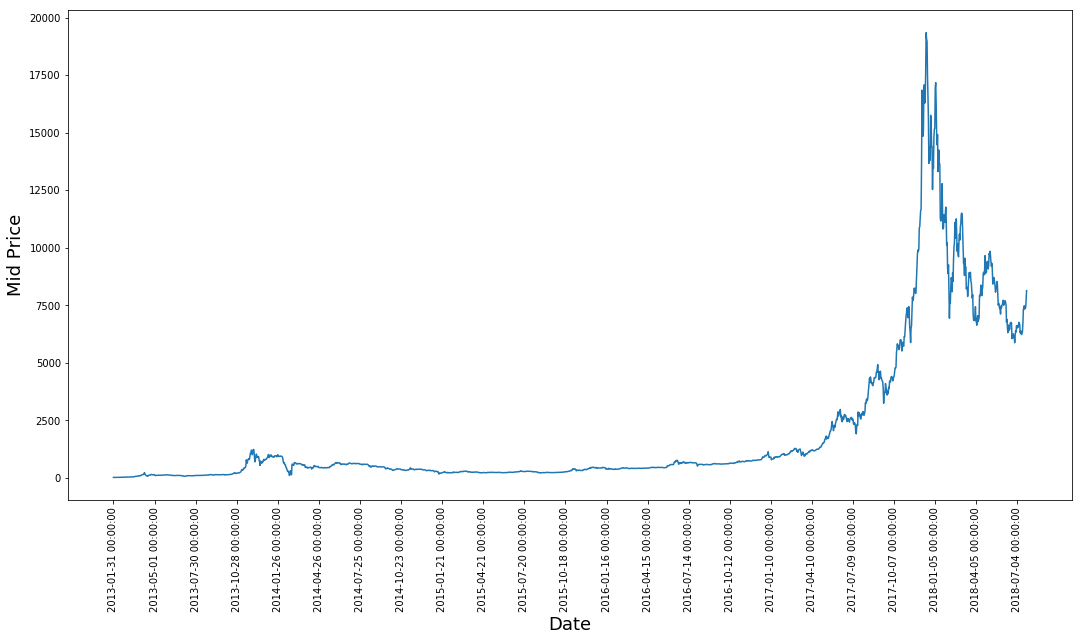

In [220]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]), data['close'])
plt.xticks(range(0, data.shape[0], 90), data['time'].loc[::90], rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

In [114]:
close = data['close']
training_data = data.iloc[:1500, 1:].as_matrix()
# y_train = data.iloc[:1500, -1].as_matrix()
test_data = data.iloc[1500:, 1:].as_matrix()
training_data.shape

(1500, 6)

In [115]:
scaler = MinMaxScaler()
training_data = training_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
training_data.shape

(9000, 1)

In [116]:
window_size = 500
for start in range(0, 1500, window_size):
    scaler.fit(training_data[start:start+window_size])
    training_data[start:start+window_size] = scaler.transform(training_data[start:start+window_size])
training_data = training_data.reshape(-1, 6)
test_data = scaler.transform(test_data).reshape(-1, 6)
training_data.shape

(1500, 6)

In [118]:
EMA = 0.0
gamma = 0.1

for i in range(1500):
    EMA = gamma*training_data[i] + (1-gamma)*EMA
    training_data[i] = EMA
    
all_data = np.concatenate([training_data, test_data], axis=0)
all_data.shape

(2001, 6)

In [143]:
def create_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [121]:
x_train, y_train = training_data[:, :-1], training_data[:, -1]
x_test, y_test = test_data[:, :-1], test_data[:, -1]

In [144]:
model = create_model([1, 5, 100, 1])

> Compilation Time :  0.020618915557861328


In [141]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape

(1500, 5, 1)

In [146]:
model.fit(x=x_train,
          y=y_train,
         batch_size=128,
         epochs=5,
         validation_split=0.05,
         verbose=2)

Train on 1425 samples, validate on 75 samples
Epoch 1/5
 - 0s - loss: 447522554144726.2500 - val_loss: 2861373784588288.0000
Epoch 2/5
 - 0s - loss: 447522496195633.6250 - val_loss: 2861373516152832.0000
Epoch 3/5
 - 0s - loss: 447522439470983.2500 - val_loss: 2861373516152832.0000
Epoch 4/5
 - 0s - loss: 447522384229792.0625 - val_loss: 2861373516152832.0000
Epoch 5/5
 - 0s - loss: 447522345636308.5000 - val_loss: 2861372979281920.0000


In [ ]:
predictions = predict_sequences_multiple(model, x_test, seq_len, 50)

In [225]:
pd.read_csv('../Data/shampoo-sales.csv', header=0, squeeze=True)

,Month,Sales of shampoo over a three year period
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9
